# Final Project

# Name: Opalina Vetrichelvan

In [1]:
#data sets for basic cover story, vs "magic"/changed cover story
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

scores_df=pd.read_csv('scores.csv')
images_df=pd.read_csv('images.csv')

In [2]:
scores_df=scores_df.filter(regex='S_')
images_df=images_df.filter(regex='S_')
scores_df.rename(columns=lambda x: x[2:], inplace=True)
images_df.rename(columns=lambda x: x[2:], inplace=True)
scores=list(scores_df.mean(axis=0))
images=list(images_df.mean(axis=0))



In [3]:
def analysis(data):
        return pd.DataFrame({"Data Type":data.dtypes, "Unique Count":data.apply(lambda x: x.nunique(),axis=0), 
                         "Null Count": data.isnull().sum() })

## Survey Data Analysis

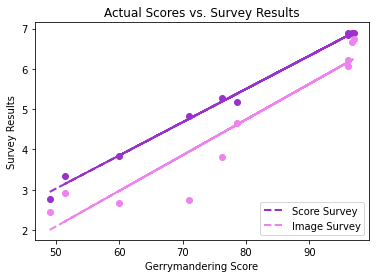

Scores Best Fit Line: y = -1.09 + 0.08x
Images Best Fit Line: y = -2.33 + 0.09x


In [4]:
x=np.array([49.01, 78.61, 97.09, 51.36, 96.79, 76.29, 96.15, 59.89, 96.05, 70.95])
fig1, ax1 = plt.subplots();
ax1.scatter(x,scores,color='darkorchid' );
ax1.scatter(x,images,color='violet' );
sa, sb = np.polyfit(x, scores, 1)
ia2, ib2 = np.polyfit(x, images, 1)
plt.plot(x, sa*x+sb, color='darkorchid', linestyle='--', linewidth=2, label='Score Survey')
plt.plot(x, ia2*x+ib2, color='violet', linestyle='--', linewidth=2, label='Image Survey')
legend = ax1.legend(loc='upper right', fontsize='x-large')
ax1.set(xlabel='Gerrymandering Score', ylabel='Survey Results', title='Actual Scores vs. Survey Results');

# Put a nicer background color on the legend.
plt.legend(loc='lower right')

plt.show()
#add fitted regression equation to plot
print('Scores Best Fit Line: y = ' + '{:.2f}'.format(sb) + ' + {:.2f}'.format(sa) + 'x')
print('Images Best Fit Line: y = ' + '{:.2f}'.format(ib2) + ' + {:.2f}'.format(ia2) + 'x')


In [5]:
def correlation(h,model):
    h=np.array(h)
    return np.corrcoef(h,model)
print("correlation for scores:", correlation(scores,x)[0][1])
print("correlation for images:", correlation(images,x)[0][1])

correlation for scores: 0.9970922114183889
correlation for images: 0.9457286098880987


In [6]:
images_stack = images_df.stack().reset_index(name='Overall_Score')
images_stack.rename({'level_1':'State'},axis=1, inplace=True)

scores_stack = scores_df.stack().reset_index(name='Overall_Score')
scores_stack.rename({'level_1':'State'},axis=1, inplace=True)

images_stack['Survey_Type']='Image Survey'
scores_stack['Survey_Type']='Score Survey'
combined=pd.concat([images_stack,scores_stack])
combined['Actual_Score']=combined['State'].str[-6:-1] 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

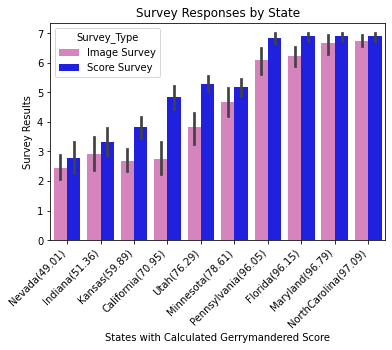

In [7]:
plt.figure()
sns.set_palette("bright")

order = combined.groupby(["State"])["Overall_Score"].mean().sort_values().index
pallete={'Image Survey':'tab:pink', 'Score Survey': 'blue'}
p=sns.barplot(x='State', y='Overall_Score', data=combined, order=order, hue='Survey_Type', palette=pallete) 
title_='Survey Responses by State'
p.set(title=title_, xlabel="States with Calculated Gerrymandered Score", ylabel='Survey Results')
plt.xticks(rotation=45, ha='right')

## Probability Calculations

In [8]:
#hypothesis 1=gerrymandered
#hypothesis 2=not gerrymandered
#Use line of best fit, a and b, to calculate probability of h1 given compactness score

def h1_D(aline,bline,score):
    y=aline*score+bline
    h1_d=y/7
    
    if h1_d>1 or h1_d<0:
        print(score,h1_d)
    return h1_d

def posterior(h1_d):
    
    h2_D=1-h1_d
    pos=np.log(h1_d/h2_D)
    return pos
    
def log_function(h1_d,a_=1,b_=0):
    ratio=posterior(h1_d)
    exp=np.exp(-a_*ratio+b_)
    return 1/(1+exp)

def transform(num):
    return num*6 +1
    
def model_predict(scores, aline,bline,a_=1, b_=0):
    model=[]
    for score in scores:
        h1_d=h1_D(aline,bline,score)
        predict=log_function(h1_d,a_,b_)
        model.append(transform(predict))
    return model


In [9]:
a_=[-1,-.5,-.25,0,.25,.5,1]
b_=[-1,-.5,-.25,0,.25,.5,1]
def get_best_ab(responses,scores,a_,b_,aline,bline):
    best_corr=0
    best_a=0
    best_b=0
    
    for aval in a_:
        for bval in b_:
            model=model_predict(scores,aline,bline,aval,bval)
            
            corr=correlation(responses,model)[0][1]
            if corr>best_corr:
                best_corr=corr
                best_a=aval
                best_b=bval
    return (best_a,best_b,best_corr)
            

In [10]:
a1,b1,corr1=get_best_ab(images,x,a_,b_,ia2,ib2)
a2,b2,corr2=get_best_ab(scores,x,a_,b_,sa,sb)
print("Image Survey to model:\nbest a:", a1, '\nbest b:', b1, '\ncorrelation:', corr1)
print("Score Survey to model:\nbest a:", a2, '\nbest b:', b2, '\ncorrelation:', corr2)

Image Survey to model:
best a: 1 
best b: 1 
correlation: 0.974074555794166
Score Survey to model:
best a: 1 
best b: 0 
correlation: 0.9970922114183889


C:\Users\Opalina\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Opalina\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Predictions based on probabilities from Image Survey

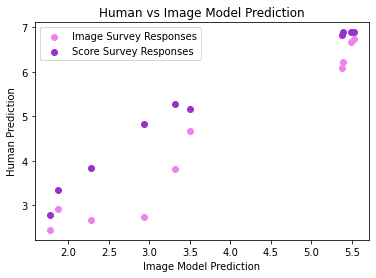

In [11]:
model_prediction_im=model_predict(x,ia2,ib2,1,1)

#add key
fig3, ax3 = plt.subplots();
ax3.scatter(model_prediction_im,images,color='violet', label='Image Survey Responses' );
ax3.scatter(model_prediction_im,scores,color='darkorchid', label="Score Survey Responses" );
legend = ax3.legend(loc='upper left')


ax3.set(xlabel='Image Model Prediction', ylabel='Human Prediction', title='Human vs Image Model Prediction');


## Predictions based on probabilities from Score Survey

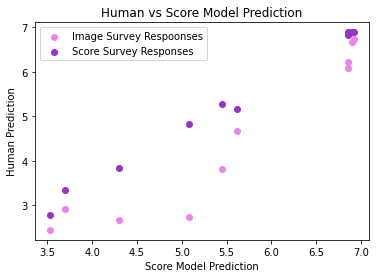

In [12]:
model_prediction=model_predict(x,sa,sb)

#add key
fig4, ax4 = plt.subplots();
ax4.scatter(model_prediction,images,color='violet',label='Image Survey Respoonses' );
ax4.scatter(model_prediction,scores,color='darkorchid', label='Score Survey Responses' );
legend = ax4.legend(loc='upper left')


ax4.set(xlabel='Score Model Prediction', ylabel='Human Prediction', title='Human vs Score Model Prediction');

## Scores Model vs. Image Model

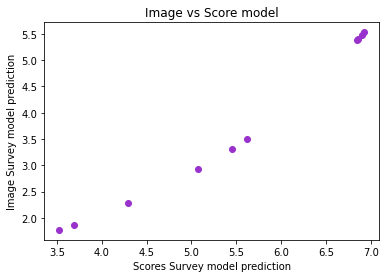

In [13]:
fig5, ax5 = plt.subplots();
ax5.scatter(model_prediction,model_prediction_im,color='darkorchid' );



ax5.set(xlabel='Scores Survey model prediction', ylabel='Image Survey model prediction', title='Image vs Score model');

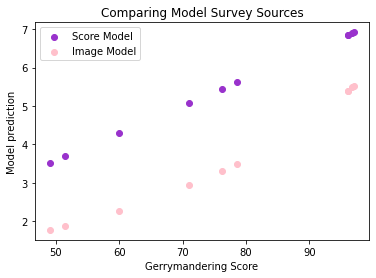

In [14]:
fig6, ax6 = plt.subplots();
ax6.scatter(x,model_prediction,color='darkorchid', label='Score Model' );
ax6.scatter(x,model_prediction_im,color='pink', label='Image Model');

legend = ax6.legend(loc='upper left')

ax6.set(xlabel='Gerrymandering Score', ylabel='Model prediction', title='Comparing Model Survey Sources');

In [15]:

print("correlation for scores:", correlation(scores,x)[0][1])
print("correlation for images:", correlation(images,x)[0][1])
print("correlation for score model, score survey:", correlation(model_prediction,scores)[0][1])
print("correlation for score model, images survey:", correlation(model_prediction,images)[0][1])
print("correlation for image model, images survey:", correlation(model_prediction_im,images)[0][1])
print("correlation for image model, score survey:", correlation(model_prediction_im,scores)[0][1])


correlation for scores: 0.9970922114183889
correlation for images: 0.9457286098880987
correlation for score model, score survey: 0.9970922114183889
correlation for score model, images survey: 0.9457286098880989
correlation for image model, images survey: 0.974074555794166
correlation for image model, score survey: 0.9848833470855562


## Image Model Predictions follow a Curved Line

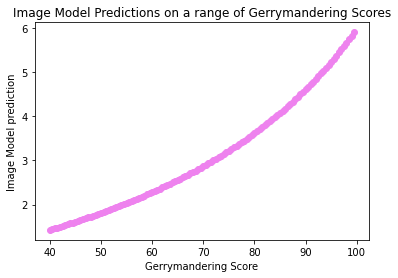

In [16]:
aray=np.arange(40,100,.5)
model_prediction_im=model_predict(aray,ia2,ib2,1,1)
fig7, ax7 = plt.subplots();
ax7.scatter(aray,model_prediction_im,color='violet', label='Image Model' );
ax7.set(xlabel='Gerrymandering Score', ylabel='Image Model prediction', title='Image Model Predictions on a range of Gerrymandering Scores');


## Survey Model Predictions Follow a Linear Line

98.5 1.0037506561875802
99.0 1.009637974758441
99.5 1.0155252933293017


<ipython-input-8-69c2cce05801>:16: RuntimeWarning: invalid value encountered in log
  pos=np.log(h1_d/h2_D)


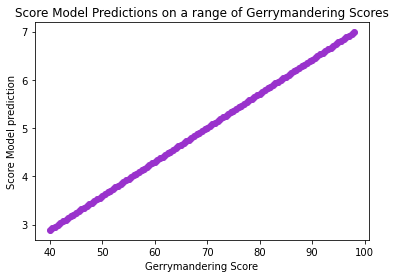

In [17]:
fig7, ax7 = plt.subplots();
model_prediction=model_predict(aray,sa,sb,1,0)

ax7.scatter(aray,model_prediction,color='darkorchid' , label='Score Model');
legend = ax6.legend(loc='upper left')

ax7.set(xlabel='Gerrymandering Score', ylabel='Score Model prediction', title='Score Model Predictions on a range of Gerrymandering Scores');